In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pygame


# Imports

In [ ]:
import numpy as np
from os import listdir
from os.path import isfile, join
import os
import math
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from numpy import linalg as LA
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics.cluster import homogeneity_score
from scipy.io import wavfile
import IPython
import IPython.display as ipd
from IPython.display import Audio
import librosa    
import librosa.display 
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Conv2D, MaxPooling2D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.regularizers import l2
import seaborn as sns
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import confusion_matrix
import itertools

# Read Audio files

In [ ]:
def read_audio(path):
  filenames = [f[:-4] for f in listdir(path) if isfile(join(path, f)) and f.endswith('wav')]
  emotion = []
  totalpath = []
  audio_signals = []#np.zeros((37371),int)
  freq = []
  CREMA_df = pd.DataFrame()
  index = 0;
  for filename in filenames:
    crema = filename + '.wav'
    total_path = os.path.join(path,crema)
    frequency_sampling, audio_signal = wavfile.read(total_path)
    audio_signals.append(audio_signal)
    freq.append(frequency_sampling)

    part = filename.split('_')
    if part[2] == 'SAD' :
         emotion.append('sad')
    elif part[2] == 'DIS' :
         emotion.append('disgust')
    elif part[2] == 'FEA' :
         emotion.append('fear')
    elif part[2] == 'HAP' :
         emotion.append('happy')
    elif part[2] == 'NEU' :
         emotion.append('neutral')
    elif part[2] == 'ANG' :
         emotion.append('angry')
    else:
         emotion.append('Unknown')
    
    totalpath.append(total_path)

    CREMA_df = pd.DataFrame(audio_signals)
    CREMA_df = CREMA_df.fillna(0)
    padding = CREMA_df.values
    data = pd.DataFrame(padding)
    CREMA_df['data']=audio_signals
    CREMA_df['label'] = emotion
    CREMA_df['freq'] = freq
    CREMA_df['path'] = totalpath
  return data,CREMA_df;

# Plot and listen Audio

In [ ]:
def plot_listen_audio(audio_arr, freq_arr):
  for audio, freq in zip(audio_arr, freq_arr):
    time_axis = 1000 * np.arange(0, len(audio), 1) / float(freq)
    plt.plot(time_axis, audio, color='blue')
    plt.xlabel('Time (milliseconds)')
    plt.ylabel('Amplitude')
    plt.title('Input audio signal')
    plt.show()
    ipd.display(Audio(data = audio, rate = freq))

# Feature Extraction

In [ ]:
def feature_extraction(audio_signals, sampling_freq):
  energy = []
  zcr = []
  melspec =[]
  # new_array = np.zeros((100, 0, 0))
  for audio, freq in zip(audio_signals, sampling_freq):

    ############### ZERO CROSSING RATE ###############

    z= librosa.feature.zero_crossing_rate(y = np.array(audio, 
                                                        dtype=float))
    zcr.append(z.T)

    ###############      ENERGY       ###############
    energy.append((librosa.feature.rms(y = np.array(audio, dtype = float),
                                center = False)).T)
    
    ###############   MELSPECTOGRAM   ###############
    mel_spectrum = librosa.feature.melspectrogram(y = np.array(audio, 
                                                              dtype=float),
                                                  center=False) 
    
    melspec.append(mel_spectrum)
  return zcr,melspec, energy


# Data Agumentation

In [ ]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape)
    return data

In [ ]:
def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)

In [ ]:
def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Main

In [ ]:
folder_path1 = '/content/drive/MyDrive/crema2'
audio_signals1,df1 = read_audio(folder_path1)



In [ ]:
folder_path2 = '/content/drive/MyDrive/crema22'
audio_signals2,df2 = read_audio(folder_path2)

In [ ]:
folder_path3 = '/content/drive/MyDrive/crema33'
audio_signals3,df3 = read_audio(folder_path3)

In [ ]:
folder_path4 = '/content/drive/MyDrive/cremmmmaaa'
audio_signals4,df4 = read_audio(folder_path4)

In [ ]:
folder_path5 = '/content/drive/MyDrive/alo'
audio_signals5,df5 = read_audio(folder_path5)

In [ ]:
df = pd.concat([df1,df2,df3,df4,df5],axis=0)

In [ ]:
audio_signal = pd.concat([audio_signals1,audio_signals2,audio_signals3,audio_signals4,audio_signals5],axis = 0)

In [ ]:
print(audio_signal.shape)
print(df.freq.shape)

(300, 330464)
(900,)


In [ ]:
audio_signal= audio_signal.fillna(0)
print(audio_signal[900])

0     -129.0
1      -46.0
2      286.0
3      271.0
4     -368.0
       ...  
295    -86.0
296     92.0
297    121.0
298    -24.0
299     23.0
Name: 900, Length: 900, dtype: float64


In [ ]:
audio_signals = audio_signal.values
print(audio_signals)

[[  30.   43.   52. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 [-232. -200. -207. ...    0.    0.    0.]
 ...
 [ 105.   95.   88. ...    0.    0.    0.]
 [ 210.  206.  208. ...    0.    0.    0.]
 [ 130.  133.  129. ...    0.    0.    0.]]


In [ ]:

#plot_listen_audio(df.data, df.freq)

labels = df.label

zero_without,melspec_df_without, energy_without = feature_extraction(audio_signals, df.freq)
#print(melspec_df_without[0][1].size)
# noise_data = noise(audio_signals, random=True)
# zero_with, melspec_df_with, energy_with = feature_extraction(noise_data, df.freq)

# stretch_data = stretch(audio_signals.flatten())
# zero_stretch , melspec_df_stretch , energy_stretch = feature_extraction(audio_signals,df.freq)

# zero_noise = zero_without + zero_with
# melspec_df_noise = melspec_df_without + melspec_df_with 
# energy_noise = energy_without + energy_with 

# zero = zero_without + zero_with + zero_stretch
# melspec_df = melspec_df_without + melspec_df_with + melspec_df_stretch
# energy = energy_without + energy_with + energy_stretch 
# label = df.label

# print(label)
# label = label.append(label)
# print(len(label))

# label_300 = label
# label_300 = label_300.append(df.label)
# print(len(label_300))


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.coolwarm_r):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix\n")
    else:
        print('Confusion matrix, without normalization\n')

    print(cm,"\n")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# CNN 2D

In [ ]:
x_train, x_test, y_train , y_test = train_test_split(melspec_df_without,
                                                     df.label, 
                                                    test_size=0.3,
                                                    random_state=42)
x_train = np.array(x_train)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_test = np.array(x_test)

x_train = x_train.reshape(-1,128,melspec_df_without[0][1].size,1)
x_test = x_test.reshape(-1,128,melspec_df_without[0][1].size,1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train/255.
x_test = x_test/255.

In [ ]:
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

lb = LabelEncoder()
print('original label str :',y_train[5])
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

  #change label from number to unique categorical 
train_Y_one_hot = to_categorical(y_train)
test_Y_one_hot = to_categorical(y_test)

  # Display the change for category label using one-hot encoding
print('Original label:', y_train[5])
print('After conversion to one-hot:', train_Y_one_hot[5])
print(train_Y_one_hot.shape)


Total number of outputs :  6
Output classes :  [0 1 2 3 4 5]
original label str : 3
Original label: 3
After conversion to one-hot: [0. 0. 0. 1. 0. 0.]
(630, 6)


In [ ]:
train_X, valid_X, train_label, valid_label = train_test_split(x_train, 
                                                            train_Y_one_hot,
                                                           test_size=0.05,
                                                           random_state=13)

In [ ]:
train_X=train_X.reshape(-1,128,melspec_df_without[0][1].size,1)
valid_X = valid_X.reshape(-1,128,melspec_df_without[0][1].size,1)

In [ ]:
train_X.shape,valid_X.shape

((598, 128, 153, 1), (32, 128, 153, 1))

In [ ]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
batch_size = 8
epochs = 20
num_classes = 6

In [ ]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(128,153,1)))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.4))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))           
fashion_model.add(Dropout(0.3))
fashion_model.add(Dense(num_classes, activation='softmax')) #change output to prob distribution

In [ ]:
fashion_model.summary()


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 128, 153, 32)      320       
_________________________________________________________________
leaky_re_lu_80 (LeakyReLU)   (None, 128, 153, 32)      0         
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 64, 77, 32)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 64, 77, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 64, 77, 64)        18496     
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 64, 77, 64)        0         
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 32, 39, 64)      

In [ ]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])


In [ ]:
fashion_train = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))


Epoch 1/20
75/75 [==============================] - 2s 23ms/step - loss: 27903.3223 - accuracy: 0.5552 - val_loss: 200059.5625 - val_accuracy: 0.3438
Epoch 2/20
75/75 [==============================] - 2s 22ms/step - loss: 30283.9121 - accuracy: 0.5201 - val_loss: 191383.7812 - val_accuracy: 0.3438
Epoch 3/20
75/75 [==============================] - 2s 22ms/step - loss: 49686.9023 - accuracy: 0.5084 - val_loss: 223162.3750 - val_accuracy: 0.2188
Epoch 4/20
75/75 [==============================] - 2s 21ms/step - loss: 34664.9609 - accuracy: 0.5117 - val_loss: 201105.0000 - val_accuracy: 0.3125
Epoch 5/20
75/75 [==============================] - 2s 21ms/step - loss: 25169.4238 - accuracy: 0.5418 - val_loss: 123944.3281 - val_accuracy: 0.3438
Epoch 6/20
75/75 [==============================] - 2s 21ms/step - loss: 16513.7539 - accuracy: 0.5753 - val_loss: 151131.1250 - val_accuracy: 0.3750
Epoch 7/20
75/75 [==============================] - 2s 22ms/step - loss: 14788.7725 - accuracy: 0.61

In [ ]:
fashion_model.save("fashion_model_dropout.h5py")


INFO:tensorflow:Assets written to: fashion_model_dropout.h5py/assets


In [ ]:
test_eval = fashion_model.evaluate(x_test, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 65496.07421875
Test accuracy: 0.41111111640930176


Found 111 correct labels
Found 159 incorrect labels
              precision    recall  f1-score   support

     Class 0       0.64      0.65      0.64        57
     Class 1       0.34      0.33      0.34        48
     Class 2       0.22      0.29      0.25        35
     Class 3       0.30      0.29      0.29        42
     Class 4       0.50      0.38      0.43        40
     Class 5       0.42      0.44      0.43        48

    accuracy                           0.41       270
   macro avg       0.40      0.39      0.40       270
weighted avg       0.42      0.41      0.41       270

Confusion matrix, without normalization

[[37  4  5  7  3  1]
 [ 5 16  7  4  4 12]
 [ 3  2 10 10  1  9]
 [ 8  5 10 12  3  4]
 [ 3  9  8  2 15  3]
 [ 2 11  5  5  4 21]] 



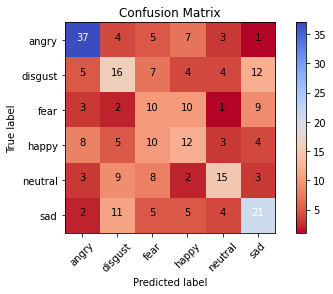

In [ ]:
predicted_classes = fashion_model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
correct = np.where(predicted_classes==y_test)[0]
print ("Found %d correct labels" % len(correct))
incorrect = np.where(predicted_classes!=y_test)[0]
print ("Found %d incorrect labels" % len(incorrect))
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_test, predicted_classes, target_names=target_names))
cm = confusion_matrix(y_true = y_test, y_pred = predicted_classes)
plot_confusion_matrix(cm = cm, classes = classes, title = 'Confusion Matrix')

# CNN 1D

In [ ]:
x_train1D, x_test1D, y_train1D , y_test1D = train_test_split(zero_without,
                                                     df.label, 
                                                    test_size=0.3,
                                                    random_state=42)
x_train1D = np.array(x_train1D)
y_train1D = np.array(y_train1D)
y_test1D = np.array(y_test1D)
x_test1D = np.array(x_test1D)

# x_train1D = x_train1D.reshape(-1,zero_without[0][1].size,1)
# x_test1D = x_test1D.reshape(-1,zero_without[0][1].size,1)

x_train1D = x_train1D.astype('float32')
x_test1D = x_test1D.astype('float32')

x_train1D = x_train1D/255.
x_test1D = x_test1D/255.

In [ ]:
classes = np.unique(y_train1D)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

lb = LabelEncoder()
print('original label str :',y_train1D[5])
y_train1D = lb.fit_transform(y_train1D)
y_test1D = lb.fit_transform(y_test1D)

  #change label from number to unique categorical 
train_Y_one_hot1D = to_categorical(y_train1D)
test_Y_one_hot1D = to_categorical(y_test1D)

  # Display the change for category label using one-hot encoding
print('Original label:', y_train1D[5])
print('After conversion to one-hot:', train_Y_one_hot1D[5])
print(train_Y_one_hot1D.shape)


Total number of outputs :  6
Output classes :  ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
original label str : happy
Original label: 3
After conversion to one-hot: [0. 0. 0. 1. 0. 0.]
(630, 6)


In [ ]:
train_X1D, valid_X1D, train_label1D, valid_label1D = train_test_split(x_train1D, 
                                                            train_Y_one_hot1D,
                                                           test_size=0.05,
                                                           random_state=13)

In [ ]:
train_X1D.shape,valid_X1D.shape

((598, 157, 1), (32, 157, 1))

In [ ]:
model = Sequential()
model.add(Conv1D(512, 1, activation='relu', input_shape=(157,1),padding='same'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(1024, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 157, 512)          1024      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 157, 512)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 155, 128)          196736    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 155, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 153, 256)          98560     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 153, 256)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 151, 512)        

In [ ]:
history = model.fit(train_X1D, train_label1D, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X1D, valid_label1D))


Epoch 1/20
75/75 [==============================] - 7s 67ms/step - loss: 1.8029 - accuracy: 0.1340 - val_loss: 1.7919 - val_accuracy: 0.1250
Epoch 2/20
75/75 [==============================] - 4s 56ms/step - loss: 1.7896 - accuracy: 0.1825 - val_loss: 1.7959 - val_accuracy: 0.1250
Epoch 3/20
75/75 [==============================] - 4s 55ms/step - loss: 1.7946 - accuracy: 0.1715 - val_loss: 1.7991 - val_accuracy: 0.1250
Epoch 4/20
75/75 [==============================] - 4s 55ms/step - loss: 1.7981 - accuracy: 0.1499 - val_loss: 1.7987 - val_accuracy: 0.1250
Epoch 5/20
75/75 [==============================] - 4s 56ms/step - loss: 1.7866 - accuracy: 0.2187 - val_loss: 1.7994 - val_accuracy: 0.1250
Epoch 6/20
75/75 [==============================] - 4s 56ms/step - loss: 1.7868 - accuracy: 0.2097 - val_loss: 1.7996 - val_accuracy: 0.1250
Epoch 7/20
75/75 [==============================] - 4s 55ms/step - loss: 1.7922 - accuracy: 0.1712 - val_loss: 1.7984 - val_accuracy: 0.1250
Epoch 8/20
75

In [ ]:
test_eval1D = model.evaluate(x_test1D, test_Y_one_hot1D, verbose=0)
print('Test loss:', test_eval1D[0])
print('Test accuracy:', test_eval1D[1])

Test loss: 1.8007744550704956
Test accuracy: 0.12962962687015533


# Data splitting

In [ ]:
def split(data_want_to_split,label):
  x_train, x_test, y_train , y_test = train_test_split(data_want_to_split,
                                                     label, 
                                                    test_size=0.3,
                                                    random_state=42)
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  y_test = np.array(y_test)
  x_test = np.array(x_test)
  return x_train,y_train,x_test,y_test

In [ ]:
def split_train_data(train,label):
  train_X, valid_X, train_label, valid_label = train_test_split(train, 
                                                            label,
                                                           test_size=0.05,
                                                           random_state=13)
  return  train_X, valid_X, train_label, valid_label

# Reshaping

In [ ]:
def reshape_data(x_train,x_test):
  #before you feed it into the network you need to convert its type to float32
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')

  x_train = x_train/255.
  x_test = x_test/255.
  return x_train,x_test

# Data prepare

In [ ]:
#Now you need to convert the class labels into a one-hot encoding vector.
def label_adjust (y_train,y_test):
#change label from str to number
  lb = LabelEncoder()
  print('original label str :',y_train[5])
  y_train = lb.fit_transform(y_train)
  y_test = lb.fit_transform(y_test)

  #change label from number to unique categorical 
  train_Y_one_hot = to_categorical(y_train)
  test_Y_one_hot = to_categorical(y_test)

  # Display the change for category label using one-hot encoding
  print('Original label:', y_train[5])
  print('After conversion to one-hot:', train_Y_one_hot[5])
  print(train_Y_one_hot.shape)
  return train_Y_one_hot,test_Y_one_hot,y_train,y_test

In [ ]:
def prepare_data(data,label,flag):
  x_train , y_train,x_test,y_test = split(data,label)
  #As a first step, convert each 128 x 97 image of the train and test set 
  #into a matrix of size 128 x 97 x 1 which is fed into the network.

  if (flag == 2):
    x_train = x_train.reshape(-1,128,melspec_df_without[0][1].size,1)
    x_test = x_test.reshape(-1,128,melspec_df_without[0][1].size,1)

  x_train,x_test = reshape_data(x_train,x_test)
  
  classes = np.unique(y_train)
  nClasses = len(classes)
  print('Total number of outputs : ', nClasses)
  print('Output classes : ', classes)
  train_Y_one_hot,test_Y_one_hot,y_train,y_test = label_adjust(y_train,y_test)
 
  train_X, valid_X, train_label, valid_label = split_train_data(x_train,train_Y_one_hot)
  if (flag == 2):
    train_X=train_X.reshape(-1,128,melspec_df_without[0][1].size,1)
    valid_X = valid_X.reshape(-1,128,melspec_df_without[0][1].size,1)

  return train_X,train_label,valid_X,valid_label,x_test,test_Y_one_hot,y_test,classes

#Accuracy

In [ ]:
def accuracy_check(model,test_x, test_lbl_hot,test_lbl,verbose):
  test_eval = model.evaluate(test_x, test_lbl_hot, verbose=verbose)
  print('Test Loss:', test_eval[0])
  print('Test Accuracy:', test_eval[1])
  print('-------------------------------------------------------')
  print('Labels Check')
  print('-------------------------------------------------------')

  predicted_classes = model.predict(test_x)
  predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
  predicted_classes.shape, test_lbl.shape
  print("\npredicted Labels : \n\n", predicted_classes)
  print("\ntesting Labels : \n\n",test_lbl)
  return predicted_classes

#F-Score

In [ ]:
def f_score(predicted_classes,test):
  target_names = ["Class {}".format(i) for i in range(len(classes))]
  print(classification_report(test, 
                              predicted_classes, 
                              target_names=target_names))

# Fit Model

In [ ]:
def fit_model(model,x_train, y_train, x_val , y_val):
  history = model.fit(x_train, y_train, 
                                  batch_size=8,
                                  epochs=40,verbose=1,
                                  validation_data=(x_val , y_val))

# **signal with noise MelSpec**

In [ ]:
train_X,train_label,valid_X,valid_label,x_test,test_Y_one_hot,y_test,classes  = prepare_data(melspec_df_noise,label , 2)


In [ ]:
model_2D_noise = CNN2D_model_1(train_X)

In [ ]:
fit_model(model_2D_noise,train_X, train_label,valid_X, valid_label)

In [ ]:
all_acc(model_2D_noise,x_test,test_Y_one_hot,y_test,1)

# **stretched signal with noise MelSpec**

In [ ]:
train_X,train_label,valid_X,valid_label,x_test,test_Y_one_hot,y_test,classes = prepare_data(melspec_df,label_300, 2)


In [ ]:
model_2D_all = CNN2D_model_1 (train_X)

In [ ]:
fit_model(model_2D_all,train_X, train_label,valid_X, valid_label)


In [ ]:
all_acc(model_2D_noise,x_test,test_Y_one_hot,y_test,1)

# **CNN 1D Model-1**

In [ ]:
def CNN1D_model_1 (x_train):
  model = Sequential()
  model.add(Conv1D(512, 1, activation='relu', input_shape=(x_train.shape[1],1),padding='same'))
  model.add(MaxPooling1D((1)))
  model.add(Conv1D(128, 3, activation='relu'))
  model.add(MaxPooling1D((1)))
  model.add(Conv1D(256, 3, activation='relu'))
  model.add(MaxPooling1D((1)))
  model.add(Conv1D(512, 3, activation='relu'))
  model.add(MaxPooling1D((1)))
  model.add(Conv1D(1024, 3, activation='relu'))
  model.add(MaxPooling1D((1)))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(6, activation='softmax'))
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
def fit_model_1D_1 (model,x_train, y_train, x_val , y_val):
  history = model.fit(x_train, y_train, 
                                  batch_size=8,
                                  epochs=20,verbose=1,
                                  validation_data=(x_val, y_val))

In [ ]:
def all_acc_1D(model):
  num_classes=6
  test_eval1D = model.evaluate(x_test1D, test_Y_one_hot1D, verbose=0)
  print('Test loss:', test_eval1D[0])
  print('Test accuracy:', test_eval1D[1])
  predicted_classes1D = model.predict(x_test1D)
  predicted_classes1D = np.argmax(np.round(predicted_classes1D),axis=1)
  predicted_classes1D.shape, y_test1D.shape
  correct1D = np.where(predicted_classes1D==y_test1D)[0]

  incorrect1D = np.where(predicted_classes1D!=y_test1D)[0]
  print ("Found %d incorrect labels" % len(incorrect1D))
  target_names1D = ["Class {}".format(i) for i in range(num_classes)]
  print(classification_report(y_test1D, predicted_classes1D, target_names=target_names1D))
  cm1D = confusion_matrix(y_true=y_test1D, y_pred=predicted_classes1D)
  plot_confusion_matrix(cm=cm1D, classes=classes, title='Confusion Matrix')

# Zero Crossing Rate pure Model1


In [ ]:
train_X1D,train_label1D,valid_X1D,valid_label1D,x_test1D,test_Y_one_hot1D,y_test1D,classes  = prepare_data(zero_without,df.label, 1)
model_zcr = CNN1D_model_1(train_X1D)
fit_model_1D_1(model_zcr,train_X1D, train_label1D,valid_X1D, valid_label1D)

Total number of outputs :  6
Output classes :  ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
original label str : happy
Original label: 3
After conversion to one-hot: [0. 0. 0. 1. 0. 0.]
(630, 6)
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 157, 512)          1024      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 157, 512)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 155, 128)          196736    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 155, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 153, 256)          98560     
__________________________________________________

Test Loss: 1.802146315574646
Test Accuracy: 0.12962962687015533
-------------------------------------------------------
Labels Check
-------------------------------------------------------

predicted Labels : 

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]

testing Labels : 

 [1 2 3 3 4 0 5 4 0 0 0 3 1 5 5 3 0 5 5 0 5 5 1 3 3 1 5 0 0 2 2 3 1 1 3 5 5
 5 5 5 3 4 1 1 3 0 2 3 2 1 5 4 5 1 4 5 5 0 1 0 2 4 2 5 3 1 0 5 3 5 0 5 1 2
 5 0 2 5 0 3 4 0 0 3 1 4 3 3 0 4 1 0 2 3 4 0 0 2 0 4 3 3 0 0 0 1 4 1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization

[[57  0  0  0  0  0]
 [48  0  0  0  0  0]
 [35  0  0  0  0  0]
 [42  0  0  0  0  0]
 [40  0  0  0  0  0]
 [48  0  0  0  0  0]] 



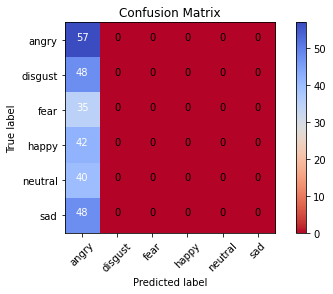

In [ ]:
# all_acc(model_zcr,x_test1D,test_Y_one_hot1D,y_test1D,0)
pred_zcr = accuracy_check(model_zcr,x_test1D,test_Y_one_hot1D,y_test1D,verbose=0)
f_score(pred_zcr,y_test1D)
cm_zcr = confusion_matrix(y_true=y_test1D, y_pred=pred_zcr)
plot_confusion_matrix(cm=cm_zcr, classes=classes, title='Confusion Matrix')

# Energy model1

In [ ]:
train_X1D_all,train_label1D_all,valid_X1D_all,valid_label1D_all,x_test1D_all,test_Y_one_hot1D_all,y_test1D_all,classes  = prepare_data(energy_without,df.label, 1)
model_energy_all = CNN1D_model_1(train_X1D_all)
fit_model_1D_1(model_energy_all,train_X1D_all, train_label1D_all,valid_X1D_all, valid_label1D_all)

Total number of outputs :  6
Output classes :  ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
original label str : happy
Original label: 3
After conversion to one-hot: [0. 0. 0. 1. 0. 0.]
(630, 6)
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 153, 512)          1024      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 153, 512)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 151, 128)          196736    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 151, 128)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 149, 256)          98560     
__________________________________________________

Test Loss: 1.5050263404846191
Test Accuracy: 0.31481480598449707
-------------------------------------------------------
Labels Check
-------------------------------------------------------

predicted Labels : 

 [3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0
 0 0 0 2 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 0 0 0 2 0 0 0 0 0]

testing Labels : 

 [1 2 3 3 4 0 5 4 0 0 0 3 1 5 5 3 0 5 5 0 5 5 1 3 3 1 5 0 0 2 2 3 1 1 3 5 5
 5 5 5 3 4 1 1 3 0 2 3 2 1 5 4 5 1 4 5 5 0 1 0 2 4 2 5 3 1 0 5 3 5 0 5 1 2
 5 0 2 5 0 3 4 0 0 3 1 4 3 3 0 4 1 0 2 3 4 0 0 2 0 4 3 3 0 0 0 1 4 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


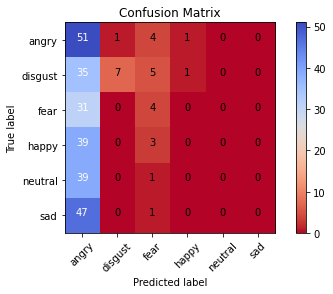

In [ ]:
# all_acc_1D(model_energy_all)
pred_energy_all = accuracy_check(model_energy_all,x_test1D_all,
                                 test_Y_one_hot1D_all,
                                 y_test1D_all,verbose=0)
f_score(pred_energy_all,y_test1D_all)
cm_energy_all = confusion_matrix(y_true=y_test1D_all, y_pred=pred_energy_all)
plot_confusion_matrix(cm=cm_energy_all, classes=classes, title='Confusion Matrix')

# Model 2

In [ ]:
def CNN1D_model_2 (x_train):
  model1 = Sequential()
  model1.add(Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(x_train.shape[1],1)))
  model1.add(BatchNormalization())
  model1.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

  model1.add(Conv1D(128, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

  model1.add(Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

  model1.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
  model1.add(BatchNormalization())
  model1.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model1.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
  model1.add(BatchNormalization())
  model1.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

  model1.add(Flatten())
  model1.add(Dropout(0.3))
  model1.add(Dense(128, activation='relu'))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.3))
  model1.add(Dense(6, activation="softmax"))

  model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

  model1.summary()
  return model1


RCV

In [ ]:
train_X1DM2,train_label1DM2,valid_X1DM2,valid_label1DM2,x_test1DM2,test_Y_one_hot1DM2,y_test1DM2,classes = prepare_data(zero_without,df.label, 1)
model_2_zcr = CNN1D_model_2(train_X1DM2)
fit_model_1D_1(model_2_zcr,train_X1DM2, train_label1DM2,valid_X1DM2, valid_label1DM2)

Total number of outputs :  6
Output classes :  ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
original label str : happy
Original label: 3
After conversion to one-hot: [0. 0. 0. 1. 0. 0.]
(630, 6)
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 157, 512)          3072      
_________________________________________________________________
batch_normalization (BatchNo (None, 157, 512)          2048      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 79, 512)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 79, 128)           327808    
_________________________________________________________________
batch_normalization_1 (Batch (None, 79, 128)           512       
__________________________________________________

Test Loss: 1.8591971397399902
Test Accuracy: 0.2222222238779068
-------------------------------------------------------
Labels Check
-------------------------------------------------------

predicted Labels : 

 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0
 0 2 2 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0
 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 2 0 2 0
 5 0 2 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 2 0 0 0
 2 0 2 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 5 0 0 2 0 0 2 0 0]

testing Labels : 

 [1 2 3 3 4 0 5 4 0 0 0 3 1 5 5 3 0 5 5 0 5 5 1 3 3 1 5 0 0 2 2 3 1 1 3 5 5
 5 5 5 3 4 1 1 3 0 2 3 2 1 5 4 5 1 4 5 5 0 1 0 2 4 2 5 3 1 0 5 3 5 0 5 1 2
 5 0 2 5 0 3 4 0 0 3 1 4 3 3 0 4 1 0 2 3 4 0 0 2 0 4 3 3 0 0 0 1 4 1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


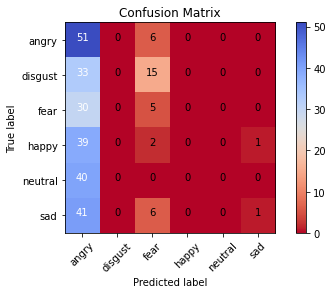

In [ ]:
pred_zcr2 = accuracy_check(model_2_zcr,
                           x_test1DM2,
                           test_Y_one_hot1DM2,
                           y_test1DM2,
                           verbose=0)
f_score(pred_zcr2,y_test1DM2)
cm_zcr2 = confusion_matrix(y_true=y_test1DM2, y_pred=pred_zcr2)
plot_confusion_matrix(cm=cm_zcr2, classes=classes, title='Confusion Matrix')

energy

In [ ]:
train_X1DM2_e,train_label1DM2_e,valid_X1DM2_e,valid_label1DM2_e,x_test1DM2_e,test_Y_one_hot1DM2_e,y_test1DM2_e,classes  = prepare_data(energy_without,df.label, 1)
model2_energy_e = CNN1D_model_2(train_X1DM2_e)
fit_model_1D_1(model2_energy_e,train_X1DM2_e, train_label1DM2_e,valid_X1DM2_e, valid_label1DM2_e)

Total number of outputs :  6
Output classes :  ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
original label str : happy
Original label: 3
After conversion to one-hot: [0. 0. 0. 1. 0. 0.]
(630, 6)
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 153, 512)          3072      
_________________________________________________________________
batch_normalization_6 (Batch (None, 153, 512)          2048      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 77, 512)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 77, 128)           327808    
_________________________________________________________________
batch_normalization_7 (Batch (None, 77, 128)           512       
__________________________________________________

Test Loss: 1.6577680110931396
Test Accuracy: 0.41111111640930176
-------------------------------------------------------
Labels Check
-------------------------------------------------------

predicted Labels : 

 [0 5 5 5 0 0 5 5 0 0 0 5 5 0 5 0 2 5 5 0 0 5 5 4 0 0 0 5 0 3 5 0 1 0 0 0 5
 5 5 5 0 5 5 5 0 0 0 0 5 0 5 0 5 5 0 0 5 4 0 0 0 0 3 5 0 0 0 5 3 5 0 5 5 3
 5 0 5 5 0 2 0 0 0 0 1 0 0 0 0 5 0 0 5 4 5 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 5
 5 5 5 0 0 5 5 3 0 0 0 5 0 0 0 0 0 0 5 0 5 0 3 0 0 0 0 5 5 5 0 4 2 5 0 0 0
 0 0 0 2 5 5 5 0 0 0 0 0 0 5 0 0 0 0 0 0 5 0 0 0 0 5 5 5 0 0 0 5 0 0 0 5 5
 0 5 5 5 5 0 5 0 0 0 3 5 5 0 0 5 0 0 0 0 5 0 0 5 0 0 0 5 0 5 5 0 5 0 0 5 0
 0 0 0 0 1 5 0 5 5 5 0 0 0 5 2 3 0 0 5 0 2 3 5 0 5 0 0 5 0 3 0 5 0 0 5 5 5
 5 0 0 0 5 2 0 5 5 0 5]

testing Labels : 

 [1 2 3 3 4 0 5 4 0 0 0 3 1 5 5 3 0 5 5 0 5 5 1 3 3 1 5 0 0 2 2 3 1 1 3 5 5
 5 5 5 3 4 1 1 3 0 2 3 2 1 5 4 5 1 4 5 5 0 1 0 2 4 2 5 3 1 0 5 3 5 0 5 1 2
 5 0 2 5 0 3 4 0 0 3 1 4 3 3 0 4 1 0 2 3 4 0 0 2 0 4 3 3 0 0 0 1 4 

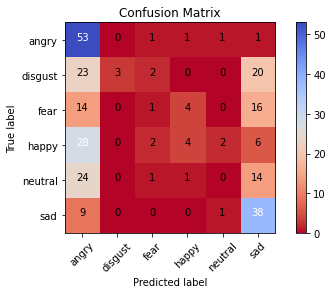

In [ ]:
p = accuracy_check(model2_energy_e,x_test1DM2_e,test_Y_one_hot1DM2_e,y_test1DM2_e,0)
f_score(p,y_test1DM2_e)
cm_energy2 = confusion_matrix(y_true=y_test1DM2_e, y_pred=p)
plot_confusion_matrix(cm=cm_energy2, classes=classes, title='Confusion Matrix')


--------------------------------------------------------------------------------------------------------

# Zero Crossing Rate Noise Model1


In [ ]:
train_X1D_noise,train_label1D_noise,valid_X1D_noise,valid_label1D_noise,x_test1D_noise,test_Y_one_hot1D_noise,y_test1D_noise,classes  = prepare_data(zero_noise,label, 1)
model_zcr_noise = CNN1D_model_1(train_X1D_noise)
fit_model_1D_1(model_zcr_noise,train_X1D_noise, train_label1D_noise,valid_X1D_noise, valid_label1D_noise)


In [ ]:
pred_zcr_noise = accuracy_check(model_zcr_noise,x_test1D_noise,
                                test_Y_one_hot1D_noise,
                                y_test1D_noise,verbose=0)
f_score(pred_zcr_noise,y_test1D_noise)
cm_zcr_noise = confusion_matrix(y_true=y_test1D_noise, y_pred=pred_zcr_noise)
plot_confusion_matrix(cm=cm_zcr_noise, classes=classes, title='Confusion Matrix')

# Zero Crossing Rate All Model1

In [ ]:
train_X1D_all,train_label1D_all,valid_X1D_all,valid_label1D_all,x_test1D_all,test_Y_one_hot1D_all,y_test1D_all,classes  = prepare_data(zero,label_300, 1)
model_zcr_all = CNN1D_model_1(train_X1D_all)
fit_model_1D_1(model_zcr_all,train_X1D_all, train_label1D_all,valid_X1D_all, valid_label1D_all)

In [ ]:
# all_acc(model_zcr_all,x_test1D_all,test_Y_one_hot1D_all,y_test1D_noise,0)
pred_zcr_all = accuracy_check(model_zcr_all,x_test1D_all,
                                test_Y_one_hot1D_all,
                                y_test1D_noise,verbose=0)
f_score(pred_zcr_noise,y_test1D_noise)
cm_zcr_noise = confusion_matrix(y_true=y_test1D_noise, y_pred=pred_zcr_noise)
plot_confusion_matrix(cm=cm_zcr_noise, classes=classes, title='Confusion Matrix')

# Zero Crossing Rate noise Model2

In [ ]:
train_X1DM2_noise,train_label1DM2_noise,valid_X1DM2_noise,valid_label1DM2_noise,x_test1DM2_noise,test_Y_one_hot1DM2_noise,y_test1DM2_noise,classes  = prepare_data(zero_noise,label, 1)
model2_zcr_noise = CNN1D_model_2(train_X1DM2_noise)
fit_model_1D_1(model2_zcr_noise,train_X1DM2_noise, train_label1DM2_noise,valid_X1DM2_noise, valid_label1DM2_noise)

In [ ]:
# all_acc_1D(model2_zcr_noise)
pred_zcr2=accuracy_check(model2_zcr_noise,x_test1DM2_noise,test_Y_one_hot1DM2_noise,y_test1DM2_noise,0)
f_score(pred_zcr2,y_test1DM2_noise)
cm_zcr2_noise = confusion_matrix(y_true=y_test1DM2_noise, y_pred=pred_zcr2)
plot_confusion_matrix(cm=cm_zcr2_noise, classes=classes, title='Confusion Matrix')

#Energy all model2

In [ ]:
train_X1DM2_all,train_label1DM2_all,valid_X1DM2_all,valid_label1DM2_all,x_test1DM2_all,test_Y_one_hot1DM2_all,y_test1DM2_all,classes  = prepare_data(energy,label_300, 1)
model2_energy_all = CNN1D_model_2(train_X1DM2_all)
fit_model_1D_1(model2_energy_all,train_X1DM2_all, train_label1DM2_all,valid_X1DM2_all, valid_label1DM2_all)

In [ ]:
pred2=accuracy_check(model2_energy_all,x_test1DM2_all,test_Y_one_hot1DM2_all,y_test1DM2_all,0)
f_score(pred2,y_test1DM2_all)
cm_energy2_all = confusion_matrix(y_true=y_test1DM2_all, y_pred=pred2)
plot_confusion_matrix(cm=cm_energy2_all, classes=classes, title='Confusion Matrix')

# Extra

In [ ]:
history1 = model1.fit(train_X1D, train_label1D, 
                                  batch_size=batch_size,
                                  epochs=epochs,verbose=1,
                                  validation_data=(valid_X1D, valid_label1D))

In [ ]:
test1_eval1D = model1.evaluate(x_test1D, test_Y_one_hot1D, verbose=0)
print('Test loss:', test1_eval1D[0])
print('Test accuracy:', test1_eval1D[1])

predicted1_classes1D = model1.predict(x_test1D)
predicted1_classes1D = np.argmax(np.round(predicted1_classes1D),axis=1)
predicted1_classes1D.shape, y_test1D.shape